In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint
from datetime import datetime

sys.path.append('../..')

In [2]:
# from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import general_arbitrage, invest_all
from model.amm.global_state import GlobalState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.exchange import Exchange
from model import run
import model.plot_utils as pu

class CEXDummy(Exchange):
    def __init__(self, tokens: dict[str: float], unique_id='dummy exchange'):
        super().__init__()
        self.prices = tokens
        self.liquidity = {tkn: 0 for tkn in tokens}
        self.asset_list = list(tokens.keys())
        self.unique_id = unique_id

    def price(self, tkn: str, denomination: str = ''):
        if denomination and denomination not in self.prices:
            raise ValueError(f'Denomination {denomination} not in exchange')
        return self.prices[tkn] / (self.prices[denomination] if denomination in self.prices else 1)

    def buy_spot(self, tkn_buy, tkn_sell, fee=0):
        return self.price(tkn_buy) / self.price(tkn_sell)

    def sell_spot(self, tkn_sell, tkn_buy, fee=0):
        return self.price(tkn_sell) / self.price(tkn_buy)

    def buy_limit(self, tkn_buy, tkn_sell):
        return float('inf')

    def sell_limit(self, tkn_buy, tkn_sell):
        return float('inf')
    
    def swap(
            self,
            agent: Agent,
            tkn_buy: str,
            tkn_sell: str,
            buy_quantity: float = 0,
            sell_quantity: float = 0
    ):
        if buy_quantity:
            sell_quantity = self.calculate_sell_from_buy(tkn_buy, tkn_sell, buy_quantity)
        elif sell_quantity:
            buy_quantity = self.calculate_buy_from_sell(tkn_buy, tkn_sell, sell_quantity)

        if tkn_buy not in agent.holdings:
            agent.holdings[tkn_buy] = 0

        agent.holdings[tkn_sell] -= sell_quantity
        agent.holdings[tkn_buy] += buy_quantity
        self.liquidity[tkn_sell] += sell_quantity
        self.liquidity[tkn_buy] -= buy_quantity

    def calculate_buy_from_sell(self, tkn_buy, tkn_sell, sell_quantity):
        return sell_quantity * self.price(tkn_sell) / self.price(tkn_buy)

    def calculate_sell_from_buy(self, tkn_sell, tkn_buy, buy_quantity):
        return buy_quantity * self.price(tkn_buy) / self.price(tkn_sell)

def get_all_token_holders(state: GlobalState, tkn):
    tkn_holders = {
        pool: pool.liquidity[tkn]
        for pool in state.pools.values()
    }
    tkn_holders.update({
        agent: agent.holdings[tkn]
        for agent in state.agents.values()
    })
    return tkn_holders

def rebase(tkn: str, rebase_amount: float):
    def evolve(state: GlobalState):
        tkn_holders = get_all_token_holders(state, tkn)
        total_supply = sum(tkn_holders.values())
        awards = 0
        for holder in tkn_holders:
            if isinstance(holder, Agent):
                awards += rebase_amount * holder.holdings[tkn] / total_supply
                holder.holdings[tkn] += rebase_amount * holder.holdings[tkn] / total_supply
            elif isinstance(holder, Exchange):
                awards += rebase_amount * holder.liquidity[tkn] / total_supply
                holder.liquidity[tkn] += rebase_amount * holder.liquidity[tkn] / total_supply
        # if (state.time_step % 100 == 0):
        #     print(total_supply)
        #     print(awards)
        return state
    return evolve

binance = CEXDummy({'S1': 1, 'S2': 1}, 'binance')
stableswap = StableSwapPoolState(
    tokens={'S1': 1000000, 'S2': 1000000},
    amplification=10,
    trade_fee=0.0005,
    unique_id='stableswap'
)
LP = Agent(
    holdings={'S1': 1000},
    trade_strategy=invest_all('stableswap'),
    unique_id='LP'
)
LP2 = Agent(
    holdings={'S2': 1000},
    trade_strategy=invest_all('stableswap'),
    unique_id='LP2'
)
non_LP = Agent(
    holdings={'S1': 500, 'S2': 500},
    trade_strategy=None,
    unique_id='non_LP'
)
arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=general_arbitrage([stableswap, binance], config=[{'exchanges': {'stableswap': ('S1', 'S2'), 'binance': ('S1', 'S2')}, 'buffer': 0}])
)
non_arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=None
)
initial_state = GlobalState(
    pools={'stableswap': stableswap, 'binance': binance},
    agents={'LP': LP, 'LP2': LP2, 'non_LP': non_LP, 'arbitrageur': arbitrageur, 'non_arbitrageur': non_arbitrageur},
    external_market={'S1': 1, 'S2': 1},
)
total_supply = sum(get_all_token_holders(initial_state, 'S1').values())
time_steps = 1000
rebase_amount = total_supply / time_steps  # double the supply
initial_state.evolve_function=rebase('S1', rebase_amount)


In [3]:
events = run.run(initial_state, time_steps=time_steps)

Starting simulation...
Execution time: 3.232 seconds.


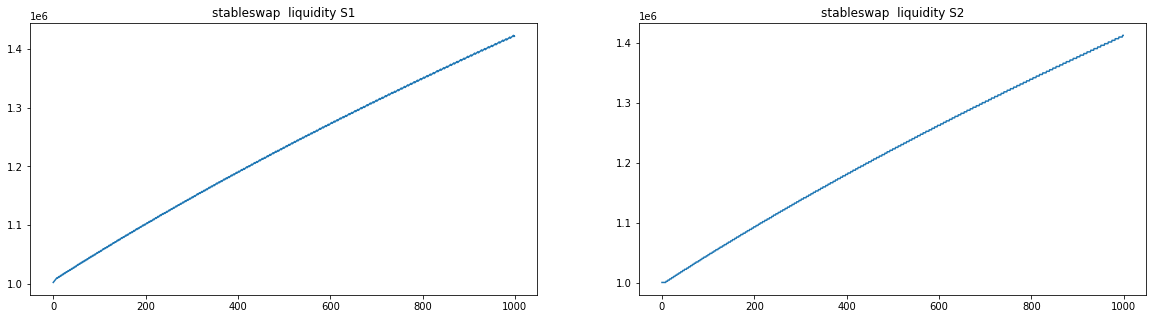

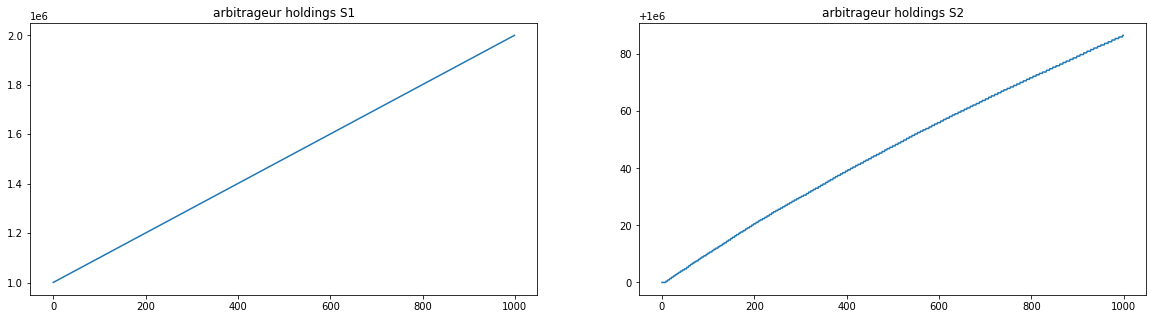

In [4]:
pu.plot(events, pool='stableswap', prop='liquidity')
pu.plot(events, agent='arbitrageur', prop='holdings', key=['S1', 'S2'])

In [5]:
print(f'Arbitrageur profit: {sum(events[-1].agents["arbitrageur"].holdings.values()) - sum(events[-1].agents["non_arbitrageur"].holdings.values())}')

Arbitrageur profit: 86.60527110937983


In [6]:
impermanent_loss = [
    (1 - event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market)
    / sum(event.agents['non_LP'].holdings.values())) * 100
    for event in events
]
total_supply = [
    sum([
        event.pools['stableswap'].liquidity['S1'], 
        event.agents['arbitrageur'].holdings['S1'], 
        event.agents['LP'].holdings['S1'], 
        event.agents['non_LP'].holdings['S1']
    ]) for event in events
]
# impermanent_loss_2 = [
#     (1 - event.pools['stableswap'].calculate_remove_liquidity(
#         event.agents['LP'], event.agents['LP'].holdings['stableswap'], 'S1'
#     ) / sum(event.agents['non_LP'].holdings.values())) * 100
#     for event in events
# ]

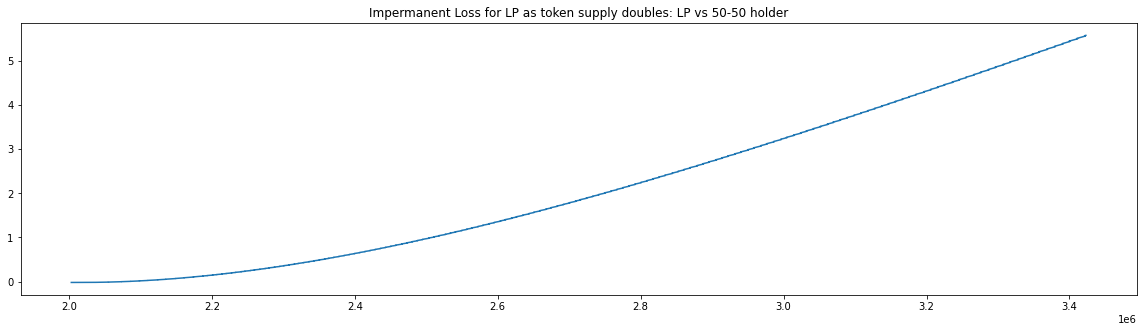

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, impermanent_loss)
# plt.plot(total_supply, impermanent_loss_2)
plt.title('Impermanent Loss for LP as token supply doubles: LP vs 50-50 holder')
plt.show()

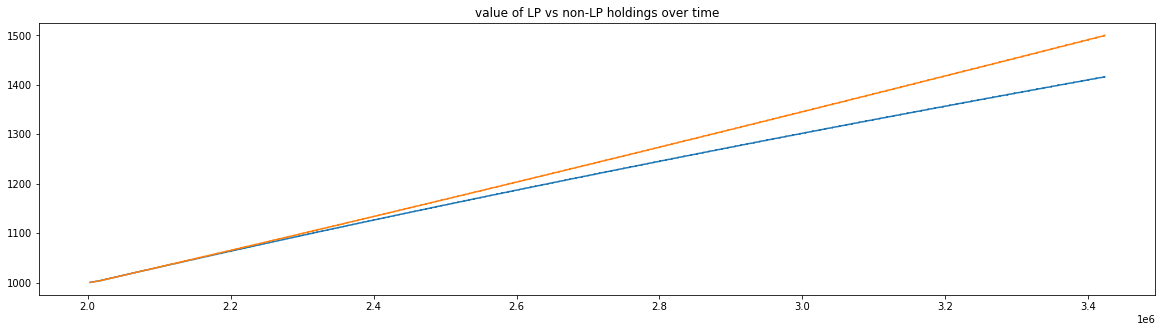

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, [event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market) for event in events])
plt.plot(total_supply, [sum(event.agents['non_LP'].holdings.values()) for event in events])
plt.title('value of LP vs non-LP holdings over time')
plt.show()

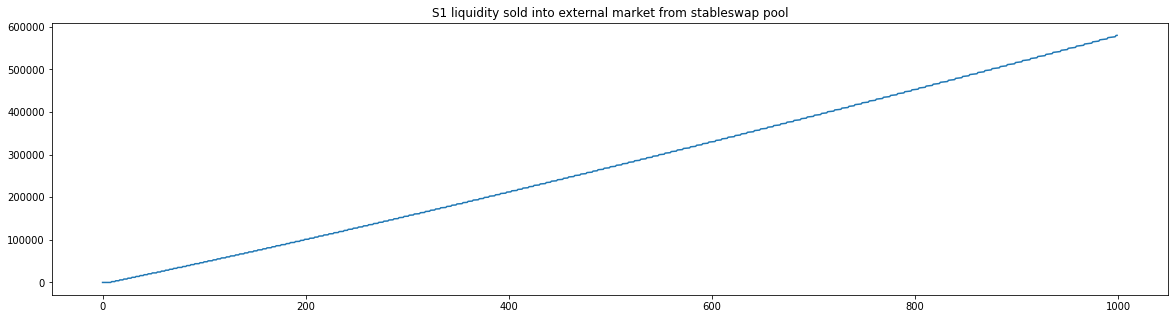

In [16]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['binance'].liquidity['S1'] for event in events])
plt.title('S1 liquidity sold into external market from stableswap pool')
plt.show()

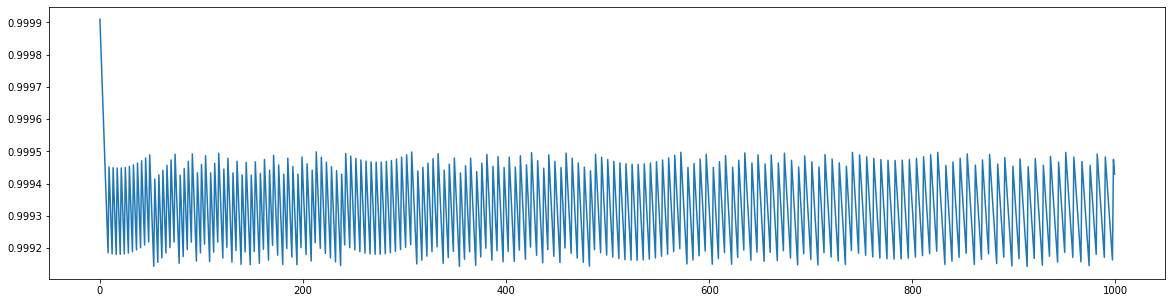

In [9]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['stableswap'].price('S1', 'S2') for event in events])

In [10]:
rebase_amount

3001.5

In [11]:
events[-1].agents['arbitrageur'], events[-1].agents['non_arbitrageur']

(Agent: arbitrageur
 ********************************
 trade strategy: general arbitrage
 holdings: (
 
     *S1*: 2000000.0
 
     *S2*: 1000086.6052711094
 
     *USD*: 0
 ),
 Agent: non_arbitrageur
 ********************************
 trade strategy: None
 holdings: (
 
     *S1*: 2000000.0
 
     *S2*: 1000000
 
     *USD*: 0
 ))

In [12]:
withdraw_agent = events[-1].agents['LP'].copy()
events[-1].pools['stableswap'].copy().remove_liquidity(
    agent=withdraw_agent,
    shares_removed=withdraw_agent.holdings['stableswap'],
    tkn_remove='S1'
)
print(withdraw_agent)
print()
print(events[-1].agents['non_LP'])

Agent: LP
********************************
trade strategy: invest all (stableswap)
holdings: (

    *S1*: 1416.3447667782

    *USD*: 0

    *S2*: 0

    *stableswap*: 0.0
)


Agent: non_LP
********************************
trade strategy: None
holdings: (

    *S1*: 1000.0

    *S2*: 500

    *USD*: 0
)



In [13]:
events[0].pools['stableswap'].liquidity, events[-1].pools['stableswap'].liquidity

({'S1': 1002001.0, 'S2': 1001000},
 {'S1': 1421933.868581509, 'S2': 1413037.2485792558})

In [14]:
events[-1].pools['binance'].liquidity['S1']

580066.1314184885